In [1]:
import sys
sys.path.insert(0,'/Users/tiagorodrigues/Documents/GitHub/NeuroKit')

import os
import wfdb
from wfdb.processing import compare_annotations
import neurokit2 as nk
import h5py
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import pickle

# Detectors comparison: Sensitivity (Se) and Positive Predictive Value (PPV) from TP, FN, FP 
Comparison of precision of the different R-peak detectors

Detectors:
- Pan and Tompkins
- Christov
- Gamboa
- Elgendi
- Engzee modified
- Kalidas
- ASI (rodrigues2020)

## 1. Detection window from the R-peak:  ( 25 samples, 100 ms)
Comparison of the detected peaks using the aforementioned algorithms and the true annotated peaks.

In [6]:
directory = r"/Users/tiagorodrigues/OneDrive - Universidade de Lisboa/TiagoRodrigues_EPFL_FieldWiz_tese_2020/Data/Annotations_Joana/Annotated_2"
rpeaks_total = 0
files = [i for i in os.listdir(directory) if i != ".DS_Store" ]
for file in files:
        filename = os.path.join(directory, file)
        f = h5py.File(filename,'r')
        
        timestamps = f['events/ECG/raw/ecg/N/timeStamps'][:,1]
        rpeaks_total = rpeaks_total + len(timestamps)    
        f.close()    
print( "Total de R-peaks:",rpeaks_total)

Total de R-peaks: 96633


In [17]:
def alldetectors_total(t_window):
    '''
    Evaluate all recordings in the folder using five different QRS complex detection methods
    input: t_window in seconds, e.g. 0.1 s
    output: dataframe with TP, TN, FP and FN
    '''
    directory = r"/Users/tiagorodrigues/OneDrive - Universidade de Lisboa/TiagoRodrigues_EPFL_FieldWiz_tese_2020/Data/Annotations_Joana/Annotated_2"

    data = {'Record':[],
            'TP':[],
            'FN':[],
            'FP':[],
            }
    detectors_total = pd.DataFrame (data)

    fs = 250
    samples_window = np.round(fs * t_window) 


    files = [i for i in os.listdir(directory) if i != ".DS_Store" ]
    for file in files:

        filename = os.path.join(directory, file)
        f = h5py.File(filename,'r')

        # Get ECG and timestamps from hdf5
        # ecg
        ecg = f['signals/ECG/raw/ecg'][:]

        # reverse polarity for engzee to work (ECG has inverted polarities)
        ecg = ecg * (-1)

        # R-peaks positions annotated (1st collumn)
        timestamps = f['events/ECG/raw/ecg/N/timeStamps'][:,1]
        timestamps = np.sort(timestamps)

        methods = ['pantompkins1985','christov2004','gamboa2008','elgendi2010','engzeemod2012','kalidas2017','rodrigues2020']
        #methods = ['rodrigues2020']
        for this_method in methods: 

            # Get annotations from the detector
            # Pth = 5 and N = 5, only used for rodrigues2020
            detector_peaks = nk.ecg_findpeaks( ecg, fs, method = this_method, show = False)
            timestamps_detector = np.asarray(detector_peaks['ECG_R_Peaks'])

            # Get physionet comparator
            comparator_object = compare_annotations(timestamps, timestamps_detector, samples_window, signal=None)

            # Get FP, FN and FP
            TP = comparator_object.tp
            FN = comparator_object.fn
            FP = comparator_object.fp

            detectors_total = detectors_total.append({'Record':file +'-'+ this_method, 'TP':TP, 'FN': FN,'FP': FP},ignore_index=True)
            f.close() 
        print(file + ": check")
    os.system('say "your program has finished"')
    return detectors_total

## Se and PPV using all methods, sample window of 25 samples (100ms):

In [18]:
# Pandas dataframe with TP, FP and FN
detectors_total = alldetectors_total(0.1) ;

# Compute Sensitivity and positive predictivity
detectors_total_se_p = [detectors_total['Record'], detectors_total['TP']/(detectors_total['TP'] + detectors_total['FN']), detectors_total['TP']/(detectors_total['TP'] + detectors_total['FP'])]
detectors_total_se_p = pd.DataFrame({'Record':detectors_total_se_p[0],'Se':detectors_total_se_p[1], 'PPV':detectors_total_se_p[2]})
detectors_total_se_p

Annotated_20200422-JT-FWv2.hdf5: check
Annotated_20200413-JM-FWv2.hdf5: check
Annotated_20200510-TR-Belt.hdf5: check
Annotated_20200505-TR-Belt.hdf5: check
Annotated_20200426-TR-FWv2.hdf5: check
Annotated_20200405-TR-FWv2.hdf5: check
Annotated_20200706-zYBko.hdf5: check
Annotated_20200421-JT-FWv2.hdf5: check
Annotated_20200508-SS-Belt.hdf5: check
Annotated_20200426-JT-FWv2.hdf5: check


,Record,Se,PPV
0,Annotated_20200422-JT-FWv2.hdf5-pantompkins1985,0.994062,0.996352
1,Annotated_20200422-JT-FWv2.hdf5-christov2004,0.998085,0.997702
2,Annotated_20200422-JT-FWv2.hdf5-gamboa2008,0.562727,0.512293
3,Annotated_20200422-JT-FWv2.hdf5-elgendi2010,0.923578,0.960558
4,Annotated_20200422-JT-FWv2.hdf5-engzeemod2012,0.994254,0.996927
...,...,...,...
65,Annotated_20200426-JT-FWv2.hdf5-gamboa2008,0.697477,0.613781
66,Annotated_20200426-JT-FWv2.hdf5-elgendi2010,0.856202,0.892915
67,Annotated_20200426-JT-FWv2.hdf5-engzeemod2012,0.996972,0.999148
68,Annotated_20200426-JT-FWv2.hdf5-kalidas2017,0.999681,0.999681


In [21]:
# Save the TN, TP, FN and FP results to pickle file
detectors_total.to_pickle("Se_P_100ms(10records).pkl")
#se_p = pickle.load("Se_P_100ms(10records).pkl')

## Compute basic statistics (mean and std) across the 10 recordings, for each detector

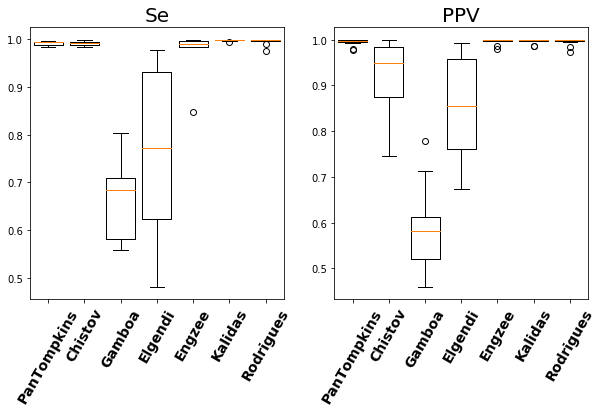

In [22]:
def compute_stats(detectors_total_se_p):
    methods = ['pantompkins1985','christov2004','gamboa2008','elgendi2010','engzeemod2012','kalidas2017','rodrigues2020']
    name_method = ['PanTompkins','Chistov','Gamboa','Elgendi','Engzee','Kalidas','Rodrigues']


    data = {'Method':[],
            'Se_mean':[],
            'Se_std':[],
            'PPV_mean':[],
            'PPV_std':[],
            }
    se_p = pd.DataFrame (data)


    fig = plt.figure(1, figsize=(10, 5))
    ax1 = fig.add_subplot(121) 
    plt.title('Se',fontsize = 20)


    ax2 = fig.add_subplot(122)   
    plt.title('PPV',fontsize = 20)


    i = 0
    for method in methods:
        thismethod_data = detectors_total_se_p[detectors_total_se_p['Record'].str.contains(methods[i])]

        se_mean = np.mean(100 * thismethod_data['Se'])
        se_std = np.std(100 * thismethod_data['Se'])
        p_mean = np.mean(100 * thismethod_data['PPV'])
        p_std = np.std(100 * thismethod_data['PPV'])


        ax1.boxplot(thismethod_data['Se'], positions = [i], widths = 0.8)
        ax2.boxplot(thismethod_data['PPV'], positions = [i],widths = 0.8)

        ax1.set_xticklabels(name_method,rotation=60, fontsize = 14, fontweight='bold')
        ax2.set_xticklabels(name_method,rotation=60, fontsize = 14, fontweight='bold')


        se_p = se_p.append({'Method':name_method[i], 
                            'Se_mean':se_mean,
                            'Se_std': se_std,
                            'PPV_mean':p_mean,
                            'PPV_std':p_std},
                           ignore_index=True)
        i=i+1
    return se_p

se_p = compute_stats(detectors_total_se_p)

# Detection window: 10 samples (40ms)

In [42]:
# Apply the QRS detectors to all the recordings and get TP, FP, TN and FN
detectors_total = alldetectors_total(0.04) 

Annotated_20200422-JT-FWv2.hdf5: check
Annotated_20200413-JM-FWv2.hdf5: check
Annotated_20200510-TR-Belt.hdf5: check
Annotated_20200505-TR-Belt.hdf5: check
Annotated_20200426-TR-FWv2.hdf5: check
Annotated_20200405-TR-FWv2.hdf5: check
Annotated_20200706-zYBko.hdf5: check
Annotated_20200421-JT-FWv2.hdf5: check
Annotated_20200508-SS-Belt.hdf5: check
Annotated_20200426-JT-FWv2.hdf5: check


In [43]:
# Save the results
detectors_total.to_pickle("Se_P_20ms(10recordings).pkl")
#detectors_total = pd.read_pickle('Se_P_20ms(10recordings).pkl')

In [44]:
# Compute Sensitivity and positive predictivity
detectors_total_se_p = [detectors_total['Record'], detectors_total['TP']/(detectors_total['TP'] + detectors_total['FN']), detectors_total['TP']/(detectors_total['TP'] + detectors_total['FP'])]
detectors_total_se_p = pd.DataFrame({'Record':detectors_total_se_p[0],'Se':detectors_total_se_p[1], 'PPV':detectors_total_se_p[2]})
detectors_total_se_p

,Record,Se,PPV
0,Annotated_20200422-JT-FWv2.hdf5-pantompkins1985,0.765754,0.767518
1,Annotated_20200422-JT-FWv2.hdf5-christov2004,0.995595,0.995213
2,Annotated_20200422-JT-FWv2.hdf5-gamboa2008,0.536870,0.488753
3,Annotated_20200422-JT-FWv2.hdf5-elgendi2010,0.920130,0.956972
4,Annotated_20200422-JT-FWv2.hdf5-engzeemod2012,0.992722,0.995391
...,...,...,...
65,Annotated_20200426-JT-FWv2.hdf5-gamboa2008,0.665604,0.585733
66,Annotated_20200426-JT-FWv2.hdf5-elgendi2010,0.841700,0.877791
67,Annotated_20200426-JT-FWv2.hdf5-engzeemod2012,0.996813,0.998989
68,Annotated_20200426-JT-FWv2.hdf5-kalidas2017,0.999575,0.999575


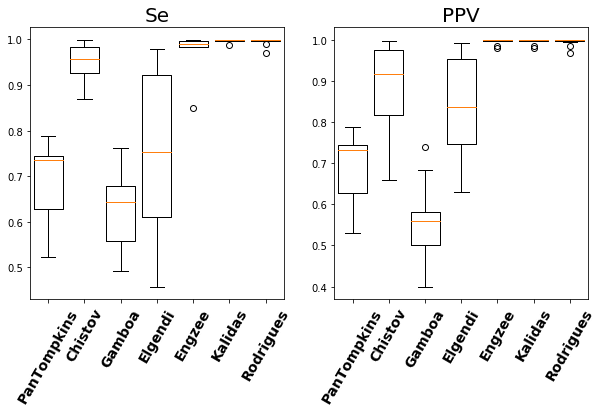

In [45]:
# Compute stats
se_p = compute_stats(detectors_total_se_p)

# Optimization of N and Pth

In [46]:
def _ecg_findpeaks_rodrigues(N, Pth, signal, sampling_rate=1000):
    """Segmenter by Tiago Rodrigues, inspired by on Gutierrez-Rivas (2015) and Sadhukhan (2012).

    References
    ----------
    - Gutiérrez-Rivas, R., García, J. J., Marnane, W. P., & Hernández, A. (2015). Novel real-time
      low-complexity QRS complex detector based on adaptive thresholding. IEEE Sensors Journal,
      15(10), 6036-6043.

    - Sadhukhan, D., & Mitra, M. (2012). R-peak detection algorithm for ECG using double difference
      and RR interval processing. Procedia Technology, 4, 873-877.
    """
    Nd = N - 1
    Rmin = 0.2
    rpeaks = []
    i = 1
    tf = len(signal)
    Ramptotal = 0

    # Double derivative squared
    diff_ecg = [int(signal[i]) - int(signal[i - Nd]) for i in range(Nd, len(signal))]
    ddiff_ecg = [diff_ecg[i] - diff_ecg[i - 1] for i in range(1, len(diff_ecg))]
    squar = np.square(ddiff_ecg)

    # Integrate moving window
    b = np.array(np.ones(N))
    a = [1]
    processed_ecg = scipy.signal.lfilter(b, a, squar)

    # R-peak finder FSM
    while i < tf - sampling_rate:  # ignore last second of recording

        # State 1: looking for maximum
        tf1 = np.round(i + Rmin * sampling_rate)
        Rpeakamp = 0
        while i < tf1:
            # Rpeak amplitude and position
            if processed_ecg[i] > Rpeakamp:
                Rpeakamp = processed_ecg[i]
                rpeakpos = i + 1
            i += 1

        Ramptotal = (19 / 20) * Ramptotal + (1 / 20) * Rpeakamp
        rpeaks.append(rpeakpos)

        # State 2: waiting state
        d = tf1 - rpeakpos
        tf2 = i + np.round(0.2 * 2 - d)
        while i <= tf2:
            i += 1

        # State 3: decreasing threshold
        Thr = Ramptotal
        while processed_ecg[i] < Thr:
            Thr *= np.exp(-Pth / sampling_rate)
            i += 1

    return rpeaks

def ecg_findpeaks(N, Pth, ecg_cleaned, sampling_rate=1000, method="neurokit", show=False):
   
    # Try retrieving right column
    if isinstance(ecg_cleaned, pd.DataFrame):
        try:
            ecg_cleaned = ecg_cleaned["ECG_Clean"]
        except NameError:
            try:
                ecg_cleaned = ecg_cleaned["ECG_Raw"]
            except NameError:
                ecg_cleaned = ecg_cleaned["ECG"]
    elif method in ["rodrigues2020", "rodrigues", "asi"]:
        rpeaks = _ecg_findpeaks_rodrigues(N, Pth, ecg_cleaned, sampling_rate)
   
    # Prepare output
    info = {"ECG_R_Peaks": rpeaks}

    return info

In [47]:
# Run through all the files
directory = r"/Users/tiagorodrigues/OneDrive - Universidade de Lisboa/TiagoRodrigues_EPFL_FieldWiz_tese_2020/Data/Annotations_Joana/Annotated_2"

data = {'Record':[],
        'TP':[],
        'FN':[],
        'FP':[],
        'N':[],
        'Pth':[],
        }
parameter_optimization = pd.DataFrame (data)


files = [i for i in os.listdir(directory) if i != ".DS_Store"]
for file in files:
    
    filename = os.path.join(directory, file)
    f = h5py.File(filename,'r')

    # Get ECG and timestamps from hdf5
    # ecg
    ecg = f['signals/ECG/raw/ecg'][:]
    
    # reverse polarity for the engzee to work
    ecg = ecg * (-1)

    # R-peaks positions annotated (1st collumn)
    timestamps = f['events/ECG/raw/ecg/N/timeStamps'][:,1]
    timestamps = np.sort(timestamps)
        
    #methods = ['pantompkins1985','christov2004','gamboa2008','elgendi2010','engzeemod2012','kalidas2017','rodrigues2020']
    methods = ['rodrigues2020']
    for this_method in methods: 
        
        N_list = np.arange(2,15)
        Pth_list = np.arange(1,10)
        for N in N_list:
            for Pth in Pth_list:
                
                # Get annotations from the detector
                detector_peaks = ecg_findpeaks(N, Pth, ecg, sampling_rate = 250, method = this_method, show = False)
                timestamps_detector = np.asarray(detector_peaks['ECG_R_Peaks'])


                # Get physionet comparator
                comparator_object = compare_annotations(timestamps, timestamps_detector, 25, signal=None)

                # Get FP, FN and FP
                TP = comparator_object.tp
                FN = comparator_object.fn
                FP = comparator_object.fp

                parameter_optimization = parameter_optimization.append({'Record':file +'-'+ this_method,
                                'TP': TP,
                                'FN': FN,
                                'FP': FP,
                                'N' : N,
                                'Pth': Pth,
                               },ignore_index=True)
                f.close()  
        print(file + ": check")
os.system('say "your program has finished"')

Annotated_20200422-JT-FWv2.hdf5: check
Annotated_20200413-JM-FWv2.hdf5: check
Annotated_20200510-TR-Belt.hdf5: check
Annotated_20200505-TR-Belt.hdf5: check
Annotated_20200426-TR-FWv2.hdf5: check
Annotated_20200405-TR-FWv2.hdf5: check
Annotated_20200706-zYBko.hdf5: check
Annotated_20200421-JT-FWv2.hdf5: check
Annotated_20200508-SS-Belt.hdf5: check
Annotated_20200426-JT-FWv2.hdf5: check


0

In [48]:
# Save Parameters Optimization dataframe to pickle TP, FN, FP, N and Pth
detectors_total.to_pickle('N_Pthparameteroptimization(10Records).pkl')
#parameter_optimization = pd.read_pickle('N_Pthparameteroptimization(10Records).pkl')

In [49]:
# Sensitivity and PPV
optimization_matrix = parameter_optimization
optimization_sep = [optimization_matrix['Record'], optimization_matrix['TP']/(optimization_matrix['TP'] + optimization_matrix['FN']), optimization_matrix['TP']/(optimization_matrix['TP'] + optimization_matrix['FP'])]
optimization_sep = pd.DataFrame({'Record':optimization_sep[0],
                                 'Se': 100 * optimization_sep[1], 
                                 'PPV': 100 * optimization_sep[2],
                                 'N': optimization_matrix['N'],
                                 'Pth': optimization_matrix['Pth'],
                                 } )
optimization_sep 
X = optimization_sep['N']
Y = optimization_sep['Pth']
Z1 = optimization_sep['Se']
Z2 = optimization_sep['PPV']

# Optimization over the different parameters (N and Pth)

In [50]:
# Compute mean and std for each value of N and Pth

N_list = np.arange(2,15)
Pth_list = np.arange(1,10)

data = {'N':N,
        'Pth':Pth,
        'Se_mean':[],
        'Se_std':[],
        'PPV_mean':[],
        'PPV_std':[],
        }
se_p = pd.DataFrame (data)

        
for N in N_list:
            for Pth in Pth_list:
                thisoptimization = optimization_sep.loc[(optimization_sep['N'] == N ) & (optimization_sep['Pth'] == Pth)]
                se_mean = np.mean( thisoptimization['Se'])
                se_std = np.std( thisoptimization['Se'])
                p_mean = np.mean( thisoptimization['PPV'])
                p_std = np.std(thisoptimization['PPV'])
    
    
                se_p = se_p.append({'N':N,
                        'Pth':Pth,
                        'Se_mean':se_mean,
                        'Se_std': se_std,
                        'PPV_mean':p_mean,
                        'PPV_std':p_std},
                         ignore_index=True)
se_p

,N,Pth,Se_mean,Se_std,PPV_mean,PPV_std
0,2.0,1.0,75.715511,6.609287,98.992352,1.364707
1,2.0,2.0,90.961767,5.726791,98.720095,1.559548
2,2.0,3.0,96.235578,3.845756,98.090449,2.457907
3,2.0,4.0,98.074856,2.377040,97.020157,3.671825
4,2.0,5.0,98.832730,1.499633,95.976093,4.792623
...,...,...,...,...,...,...
112,14.0,5.0,99.609828,0.705105,98.997150,1.290667
113,14.0,6.0,99.761469,0.392455,98.562571,1.549688
114,14.0,7.0,99.809467,0.297301,97.833051,2.145220
115,14.0,8.0,99.843114,0.210963,96.908302,3.005824


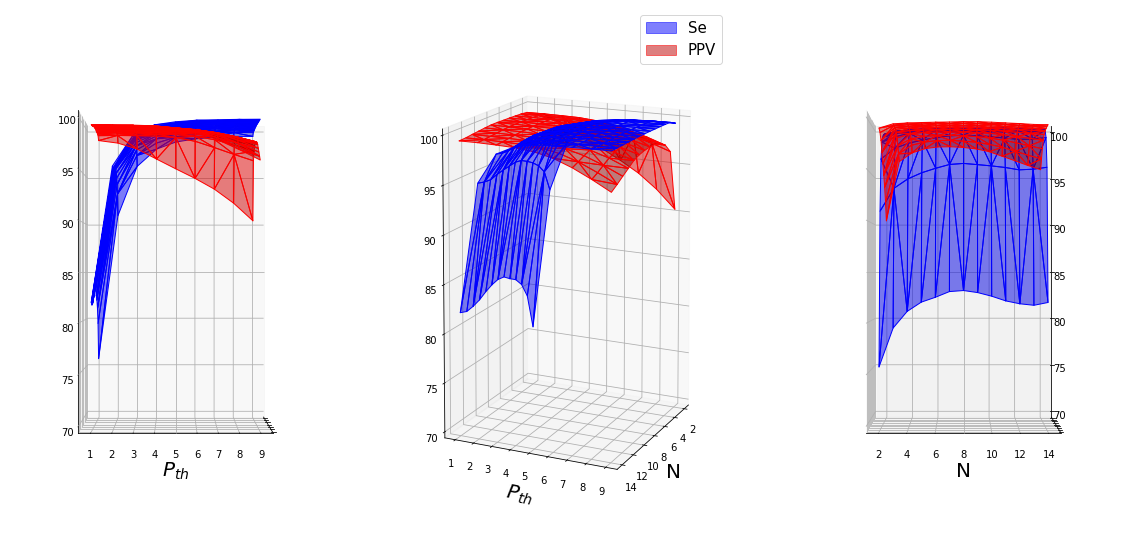

In [55]:
from mpl_toolkits.mplot3d import Axes3D


optimization_matrix = parameter_optimization

# Sensitivity and positive predictivity
optimization_sep = [optimization_matrix['Record'], optimization_matrix['TP']/(optimization_matrix['TP'] + optimization_matrix['FN']), optimization_matrix['TP']/(optimization_matrix['TP'] + optimization_matrix['FP'])]
optimization_sep = pd.DataFrame({'Record':optimization_sep[0],
                                 'Se':optimization_sep[1], 
                                 'PPV':optimization_sep[2],
                                 'N': optimization_matrix['N'],
                                 'Pth': optimization_matrix['Pth'],
                                } )
optimization_sep = se_p
X = optimization_sep['N']
Y = optimization_sep['Pth']
Z1 = optimization_sep['Se_mean']
Z2 = optimization_sep['PPV_mean']


# LEFT PLOT
# Plot X,Y,Z
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(131, projection='3d')
ax.plot_trisurf(X, Y, Z1, color='blue', edgecolors='b', alpha=0.5,label = 'Se')
ax.plot_trisurf(X, Y, Z2, color='red', edgecolors='r', alpha=0.5, label = 'PPV')
ax.set_ylabel('$P_{th}$',fontsize = 20)
ax.view_init(azim=0, elev=0)
ax.set_xticklabels([])
ax.set_zlim(70, 100)



# MID PLOT
ax2 = fig.add_subplot(132, projection='3d')
surf1 = ax2.plot_trisurf(X, Y, Z1, color='blue', edgecolors='b', alpha=0.5,label = 'Se')
surf2 = ax2.plot_trisurf(X, Y, Z2, color='red', edgecolors='r', alpha=0.5, label = 'PPV')
ax2.set_xlabel('N',fontsize = 20)
ax2.set_ylabel('$P_{th}$',fontsize = 20)
ax2.view_init(azim=25, elev=10)


surf1._facecolors2d = surf1._facecolors3d
surf1._edgecolors2d = surf1._edgecolors3d

surf2._facecolors2d = surf1._facecolors3d
surf2._edgecolors2d = surf1._edgecolors3d
ax2.legend(fontsize = 15)
ax2.set_zlim(70, 100)



# RIGHT PLOT
ax3 = fig.add_subplot(133, projection='3d')
ax3.plot_trisurf(X, Y, Z1, color='blue', edgecolors='b', alpha=0.5,label = 'Se')
ax3.plot_trisurf(X, Y, Z2, color='red', edgecolors='r', alpha=0.5, label = 'PPV')
ax3.set_xlabel('N',fontsize = 20)
ax3.set_yticklabels([])
ax3.view_init(azim=270, elev=0)
ax3.set_zlim(70, 100)


# Azul - Sensitivity
# Vermelho - PPV

plt.show()